# Diabetic Retinopathy Detection — ODIR-5K
 

## 1. Configure GPU / CUDA for RTX 4060



This section checks GPU availability and configures TensorFlow to use the GPU with mixed precision and memory growth. If you run this on a machine with an NVIDIA RTX 4060 and proper drivers/CUDA/cuDNN installed, TensorFlow will pick it up. If using a remote GPU (Colab / cluster) ensure matching CUDA versions.

In [2]:
import os, tensorflow as tf
print('TensorFlow version:', tf.__version__)

# Enable mixed precision for faster training on modern GPUs
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print('Mixed precision enabled.')
except Exception as e:
    print('Mixed precision not enabled:', e)

# List physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print('GPUs found:', gpus)
if gpus:
    try:
        # Set memory growth to avoid allocating all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        print(e)

# Recommended: set CUDA visible devices if you have multiple GPUs (uncomment and set index)
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'


TensorFlow version: 2.10.1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9
Mixed precision enabled.
GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## 2. Imports and general setup

 

In [3]:

# 2. Imports
import numpy as np
import pandas as pd
import os, glob, json, random, pathlib, math, itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.preprocessing import image as kimage
import tensorflow_addons as tfa

print('Imported libraries. tf version:', tf.__version__)


Imported libraries. tf version: 2.10.1


c:\Users\rsp05\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\rsp05\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

### Paths, reproducibility and runtime variables

 

In [4]:

# 2.1 Paths and seeds
DATA_DIR = r"E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data"
# If running on Linux or container, you might mount this drive and update DATA_DIR accordingly.
print('DATA_DIR =', DATA_DIR)

RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


DATA_DIR = E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data


## 3. Data Loading and Exploration

The dataset is provided as `.npz` files inside `train`, `val`, and `test` subfolders. Each `.npz` typically contains an image array and related metadata (for ODIR: fields such as 'slo fundus', 'male', and labels). We'll scan directories, inspect a few files, and build a dataframe with file paths and metadata (label, gender, id, split).

In [5]:

# 3.1 Helper to scan npz files and build dataframe
import numpy as np, os
from pathlib import Path

def scan_npz_folder(folder, split_name):
    rows = []
    for fp in Path(folder).glob('*.npz'):
        try:
            data = np.load(fp, allow_pickle=True)

            # Extract label and gender using the actual NPZ keys
            label = data['dr_class'].item() if hasattr(data['dr_class'], 'item') else data['dr_class']
            gender = data['male'].item() if hasattr(data['male'], 'item') else data['male']

            rows.append({
                'file': str(fp),
                'split': split_name,
                'keys': list(data.keys()),
                'label_raw': label,
                'gender_raw': gender
            })

        except Exception as e:
            print("Error loading", fp, ":", e)

    return pd.DataFrame(rows)


# Scan train/val/test if they exist
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')

dfs = []
for p, s in [(train_dir, 'train'), (val_dir, 'val'), (test_dir, 'test')]:
    if os.path.exists(p):
        print('Scanning', p)
        dfs.append(scan_npz_folder(p, s))
    else:
        print('Path not found:', p)

df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame(columns=['file','split','keys','label_raw','gender_raw'])
print('Total samples found:', len(df))
df.head(8)

for split in ['train', 'val', 'test']:
    count = len(df[df['split'] == split])
    print(f"{split} samples: {count}")


Scanning E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data\train
Scanning E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data\val
Scanning E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data\test
Total samples found: 7031
train samples: 4476
val samples: 641
test samples: 1914


### 3.2 Quick visualization: show sample images and label/gender distribution

 

Unique gender values: [0 1]


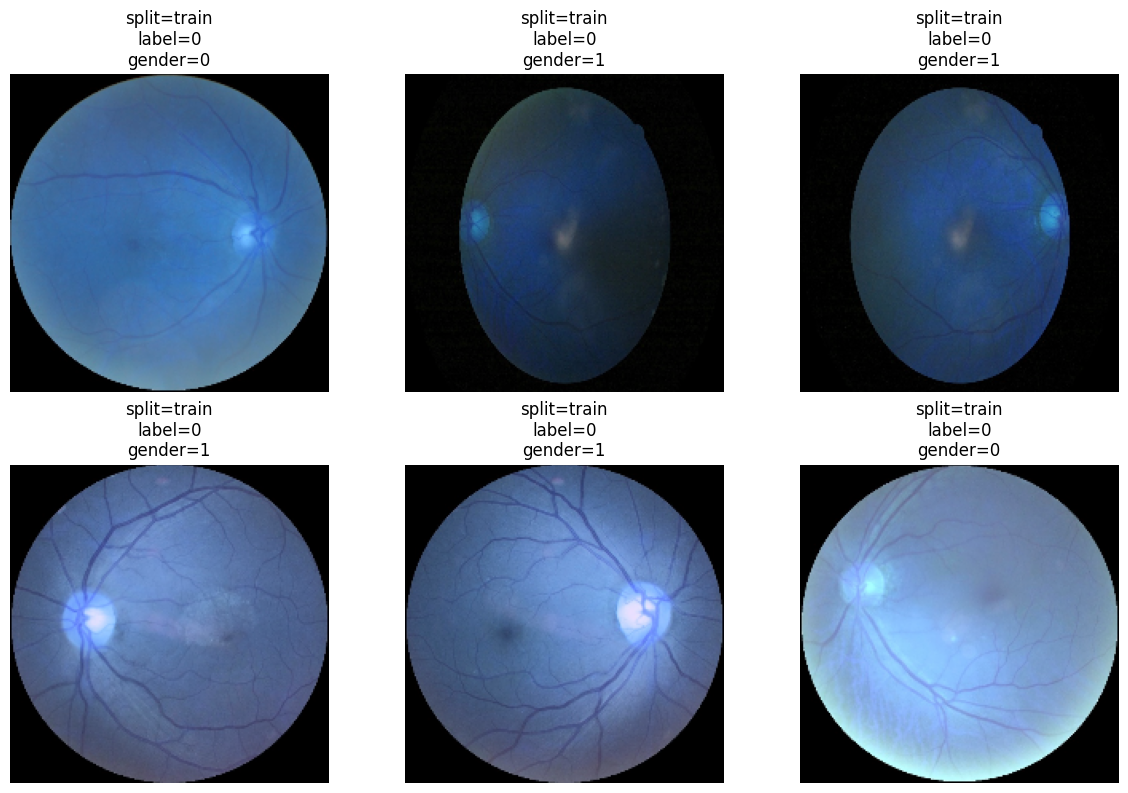

In [6]:

# 3.2 Display sample images (adapt to how images are stored in your npz; here we try common keys)
def load_image_from_npz(fp):
    data = np.load(fp, allow_pickle=True)
    # Common keys that may hold fundus image arrays
    for key in ['fundus', 'slo fundus', 'slo_fundus', 'image', 'img', 'fundus_rgb']:
        if key in data:
            arr = data[key]
            return arr
    # Fallback: if only one array present, return it
    keys = list(data.keys())
    for k in keys:
        arr = data[k]
        # heuristics: pick array with shape looks like image (H,W,3)
        if hasattr(arr, 'shape') and len(arr.shape) >= 2 and arr.shape[-1] in (3,4):
            return arr
    return None

# show first 6 images
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
n = min(6, len(df))
for i, row in df.head(n).iterrows():
    arr = load_image_from_npz(row['file'])
    plt.subplot(2,3,i+1)
    if arr is None:
        plt.text(0.5,0.5,'No image found',ha='center',va='center')
    else:
        # normalize if needed
        if arr.max() > 1.5:
            arr_disp = (arr / 255.0).clip(0,1)
        else:
            arr_disp = arr.clip(0,1)
        plt.imshow(arr_disp)
    title = f"split={row['split']}\nlabel={row['label_raw']}\ngender={row['gender_raw']}"
    plt.title(title)
    plt.axis('off')
plt.tight_layout()

#Count distribution
# dist = df.groupby(['gender_raw', 'label_raw']).size().unstack(fill_value=0)

# plt.figure(figsize=(10,6))
# dist.plot(kind='bar', figsize=(10,6))

# plt.xlabel("Gender")
# plt.ylabel("Count")
# plt.title("Label Distribution Across Genders")

# plt.xticks(rotation=0)
# plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

# Check gender values
print("Unique gender values:", df['gender_raw'].unique())



Gender and Class Distribution on DataSet

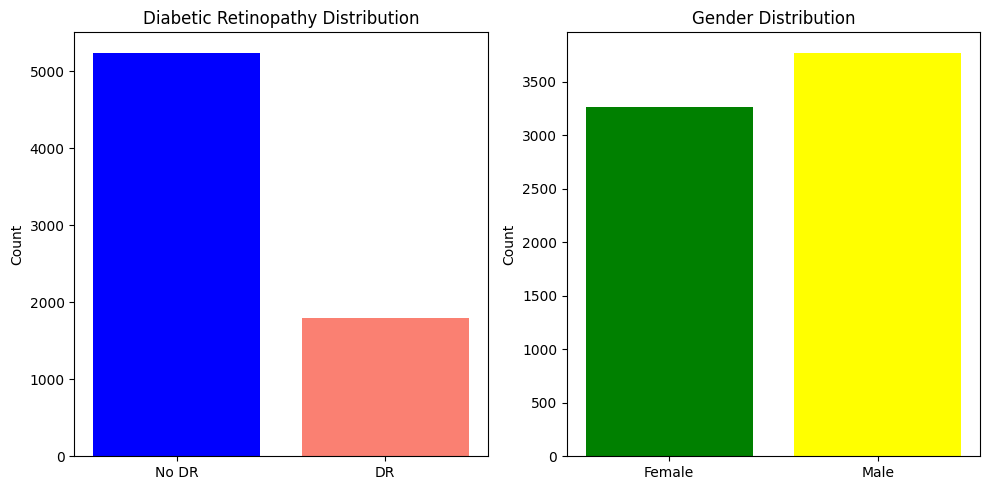

In [6]:
# Counts for DR labels
counts = df['label_raw'].value_counts().sort_index()
label_mapping = {0: 'No DR', 1: 'DR'}
counts.index = counts.index.map(label_mapping)

# Counts for gender
gender_counts = df['gender_raw'].dropna().value_counts().sort_index()
# Adjust this mapping according to your df values
gender_mapping = {'F': 'Female', 'M': 'Male', 'Female': 'Female', 'Male': 'Male', 0: 'Female', 1: 'Male'}
gender_counts.index = gender_counts.index.map(gender_mapping)

# Plot subplots
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.bar(counts.index, counts.values, color=['blue', 'salmon'])
plt.title('Diabetic Retinopathy Distribution')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(gender_counts.index, gender_counts.values, color=['green', 'yellow'])
plt.title('Gender Distribution')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

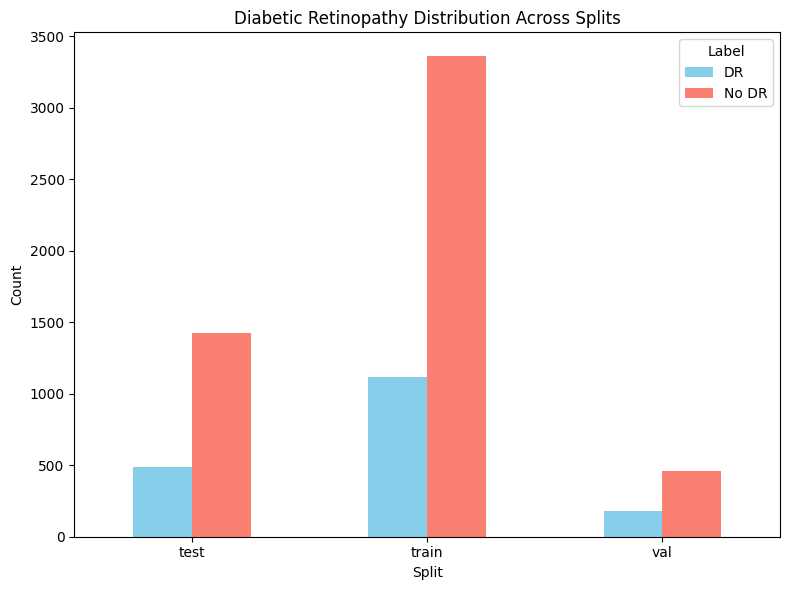

In [7]:
import matplotlib.pyplot as plt

# Map labels to readable names
label_mapping = {0: 'No DR', 1: 'DR'}  # adjust if needed
df['label_name'] = df['label_raw'].map(label_mapping)

# Count labels per split
split_label_counts = df.groupby(['split', 'label_name']).size().unstack(fill_value=0)

# Plot grouped bar
split_label_counts.plot(kind='bar', figsize=(8,6), color=['skyblue', 'salmon'])

plt.xlabel("Split")
plt.ylabel("Count")
plt.title("Diabetic Retinopathy Distribution Across Splits")
plt.xticks(rotation=0)
plt.legend(title="Label")
plt.tight_layout()
plt.show()


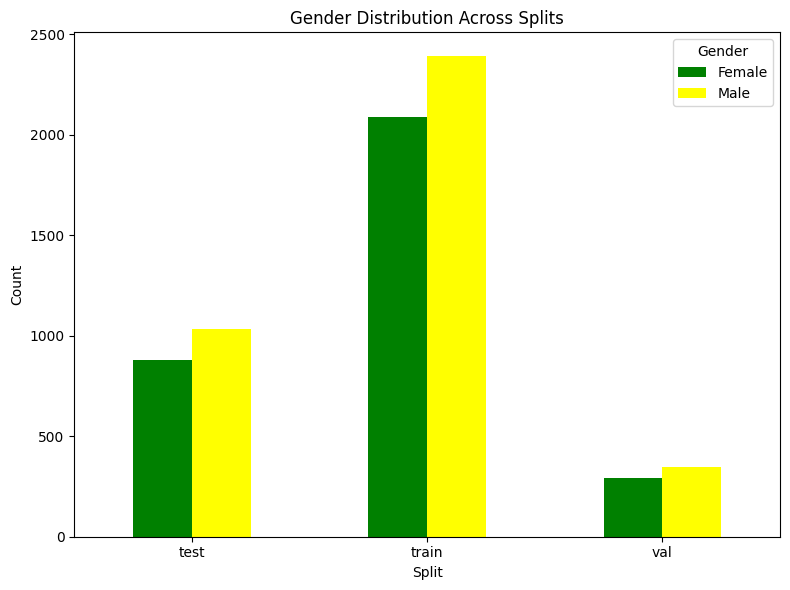

In [8]:
import matplotlib.pyplot as plt

# Map genders to readable names
gender_mapping = {'F': 'Female', 'M': 'Male', 'Female': 'Female', 'Male': 'Male', 0: 'Female', 1: 'Male'}
df['gender_name'] = df['gender_raw'].map(gender_mapping)

# Count genders per split
split_gender_counts = df.groupby(['split', 'gender_name']).size().unstack(fill_value=0)

# Plot grouped bar
split_gender_counts.plot(kind='bar', figsize=(8,6), color=['green', 'yellow'])

plt.xlabel("Split")
plt.ylabel("Count")
plt.title("Gender Distribution Across Splits")
plt.xticks(rotation=0)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


## 4. Data Preprocessing and Augmentation

We'll create a `tf.data.Dataset` pipeline that reads `.npz`, extracts the image and label, decodes/resizes to 224×224, applies augmentations (random flip, rotation, brightness, zoom). Use `prefetch`, `cache` where appropriate for speed. For reproducibility, keep augmentation consistent across experiments.

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

# ---------------------------------------------
# 1. Preprocessing (same as your original code)
# ---------------------------------------------
def preprocess_image(fp):
    """Load and preprocess image for TF dataset."""
    arr = load_image_from_npz(fp)

    # Convert to float32 tensor
    img = tf.convert_to_tensor(arr, dtype=tf.float32)

    # If grayscale (H, W), convert to 3-channel
    if img.ndim == 2:
        img = tf.stack([img] * 3, axis=-1)

    # Normalize and resize
    if tf.reduce_max(img) > 1.5:
        img = img / 255.0

    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img


def tf_load_function(file_path, label):
    """Wrapper for tf.data pipeline."""
    img = tf.numpy_function(preprocess_image, [file_path], tf.float32)
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))

    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, ())
    return img, label


# ---------------------------------------------
# 2. Training Augmentation Layer
# ---------------------------------------------
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


# ---------------------------------------------
# 3. Dataset builder (with optional augmentation)
# ---------------------------------------------
def make_dataset(df_split, augment=False):
    file_paths = df_split['file'].values
    labels     = df_split['label_raw'].values

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(tf_load_function, num_parallel_calls=tf.data.AUTOTUNE)

    # Add augmentation only during training
    if augment:
        ds = ds.map(lambda x, y: (data_augment(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


# ---------------------------------------------
# 4. Create final datasets
# ---------------------------------------------
train_ds = make_dataset(df[df['split'] == 'train'], augment=True)
val_ds   = make_dataset(df[df['split'] == 'val'],   augment=False)
test_ds  = make_dataset(df[df['split'] == 'test'],  augment=False)




# Compute Class Weights

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# training labels as integers 0/1
y_train = df[df['split']=='train']['label_raw'].values.astype(int)

cw = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0,1]),
    y=y_train
)

# Convert to Python floats
class_weights = {0: float(cw[0]), 1: float(cw[1])}

print(class_weights)  # should print {0: 0.xx, 1: 1.xx}
print(type(class_weights[0]), type(class_weights[1]))  # <class 'float'>


{0: 0.6664681357951161, 1: 2.001788908765653}
<class 'float'> <class 'float'>


# Define Callbacks

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

OUTPUT_DIR = r"E:\Phd\2-Fall 2025\Data Mining 566\Final Project\models_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def get_callbacks(model_name):
    model_path = os.path.join(OUTPUT_DIR, f"{model_name}_best.h5")

    ckpt = ModelCheckpoint(
        filepath=model_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,   # Keep full model
        verbose=1
    )

    early = EarlyStopping(
        monitor="val_loss",
        patience=7,               # Slightly larger patience
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        min_lr=1e-7,              # important for stability
        verbose=1
    )

    return [ckpt, early, reduce_lr]


## Model Implementations 

Build EfficientNet Model

In [30]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam

def build_efficientnet(train_base=False, lr=1e-3, dropout_rate=0.3, l2=1e-4):
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base = EfficientNetB0(include_top=False, weights="imagenet",
                          input_tensor=inp, pooling="avg")
    base.trainable = train_base

    x = layers.Dropout(dropout_rate)(base.output)
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer=Adam(lr),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model


eff_model = build_efficientnet()
eff_model.summary()



# two phase 
# from tensorflow.keras import layers, models, regularizers
# from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
# from tensorflow.keras.optimizers import Adam
# import tensorflow as tf


# def build_efficientnet(dropout_rate=0.4, l2=1e-4, lr=1e-3, train_base=False):
#     inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

#     base = EfficientNetB0(include_top=False, weights='imagenet',
#                           input_tensor=inp, pooling='avg')
#     base.trainable = train_base

#     x = layers.Dropout(dropout_rate)(base.output)
#     x = layers.Dense(128, activation='relu',
#                      kernel_regularizer=regularizers.l2(l2))(x)
#     x = layers.Dropout(dropout_rate)(x)

#     out = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

#     model = models.Model(inp, out)

#     model.compile(
#         optimizer=Adam(lr),
#         loss='binary_crossentropy',
#         metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
#     )
#     return model
# eff_model = build_efficientnet()
# eff_model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']    

Build DenseNet Model

In [19]:
from tensorflow.keras.applications import DenseNet121

def build_densenet(dropout_rate=0.3, l2=1e-4):
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base = DenseNet121(include_top=False, weights='imagenet',
                       input_tensor=inp, pooling='avg')

    x = layers.Dropout(dropout_rate)(base.output)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(dropout_rate)(x)

    out = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

dense_model = build_densenet()
dense_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 # # Train the Models

# Train EfficientNetB0

Two Phase Effnet Training

In [ ]:
# # 1. Build model with base frozen
# eff_model = build_efficientnet(train_base=False, lr=1e-3)

# # 2. Train for few epochs
# history_eff_phase1 = eff_model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     class_weight=class_weights,
#     callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=5, restore_best_weights=True)]
# )
# # 3. Unfreeze the base for fine-tuning
# eff_model = build_efficientnet(train_base=True, lr=1e-5)

# # 4. Train again on the same dataset
# history_eff_phase2 = eff_model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=40,
#     class_weight=class_weights,
#     callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=8, restore_best_weights=True)]
# )


Epoch 1/10
140/140 [==============================] - 61s 337ms/step - loss: 0.5813 - accuracy: 0.7357 - auc: 0.7900 - val_loss: 0.8711 - val_accuracy: 0.2855 - val_auc: 0.5000
Epoch 2/10
140/140 [==============================] - 52s 357ms/step - loss: 0.6761 - accuracy: 0.6242 - auc: 0.7060 - val_loss: 0.7975 - val_accuracy: 0.2855 - val_auc: 0.5000
Epoch 3/10
140/140 [==============================] - 51s 351ms/step - loss: 0.7034 - accuracy: 0.5132 - auc: 0.6255 - val_loss: 0.7568 - val_accuracy: 0.2855 - val_auc: 0.5000
Epoch 4/10
140/140 [==============================] - 50s 342ms/step - loss: 0.6448 - accuracy: 0.6783 - auc: 0.7284 - val_loss: 0.7578 - val_accuracy: 0.2855 - val_auc: 0.5000
Epoch 5/10
140/140 [==============================] - 53s 361ms/step - loss: 0.6919 - accuracy: 0.5427 - auc: 0.5880 - val_loss: 0.7589 - val_accuracy: 0.2855 - val_auc: 0.5000
Epoch 6/10
140/140 [==============================] - 51s 349ms/step - loss: 0.6964 - accuracy: 0.6450 - auc: 0.661

In [ ]:
# def merge_histories(h1, h2):
#     merged = {}
#     for key in h1.history.keys():
#         merged[key] = h1.history[key] + h2.history[key]
#     return merged
# merged_eff = merge_histories(history_eff_phase1, history_eff_phase2)


In [ ]:
# def plot_history_dict(history_dict, title):
#     plt.figure(figsize=(15,5))

#     # Accuracy
#     plt.subplot(1,2,1)
#     plt.plot(history_dict['accuracy'])
#     plt.plot(history_dict['val_accuracy'])
#     plt.title(title + " Accuracy")
#     plt.legend(['train', 'val'])

#     # AUC
#     plt.subplot(1,2,2)
#     plt.plot(history_dict['auc'])
#     plt.plot(history_dict['val_auc'])
#     plt.title(title + " AUC")
#     plt.legend(['train', 'val'])

#     plt.show()
# plot_history_dict(merged_eff, "EfficientNet Two-Phase Training")


Single Phase Effnet Training

In [18]:
history_eff = eff_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=[]
)

# # Save full model
# eff_full_path = os.path.join(OUTPUT_DIR, "EfficientNetB0_full_model")
# eff_model.save(eff_full_path)

# # Save training history
# with open(os.path.join(OUTPUT_DIR, "EfficientNetB0_history.json"), "w") as f:
#     json.dump(history_eff.history, f)

Epoch 1/50
140/140 [==============================] - 107s 678ms/step - loss: 0.7000 - accuracy: 0.6866 - auc: 0.6960 - val_loss: 0.7779 - val_accuracy: 0.2855 - val_auc: 0.4345
Epoch 2/50
140/140 [==============================] - 98s 682ms/step - loss: 0.7449 - accuracy: 0.5523 - auc: 0.5400 - val_loss: 0.7789 - val_accuracy: 0.2855 - val_auc: 0.5472
Epoch 3/50
140/140 [==============================] - 98s 682ms/step - loss: 0.7350 - accuracy: 0.5007 - auc: 0.5031 - val_loss: 0.6915 - val_accuracy: 0.7036 - val_auc: 0.4103
Epoch 4/50
140/140 [==============================] - 99s 692ms/step - loss: 0.7184 - accuracy: 0.5112 - auc: 0.5393 - val_loss: 0.7306 - val_accuracy: 0.5133 - val_auc: 0.3928
Epoch 5/50
140/140 [==============================] - 99s 694ms/step - loss: 0.7074 - accuracy: 0.5393 - auc: 0.5727 - val_loss: 1.8488 - val_accuracy: 0.3947 - val_auc: 0.4240
Epoch 6/50
140/140 [==============================] - 97s 675ms/step - loss: 0.7071 - accuracy: 0.5380 - auc: 0.57

Train DenseNet121

In [23]:
callbacks_dense = get_callbacks("DenseNet121")

history_dense = dense_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks_dense
)

Epoch 1/50
140/140 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.7451 - auc: 0.7892
Epoch 1: val_loss improved from inf to 0.60045, saving model to E:\Phd\2-Fall 2025\Data Mining 566\Final Project\models_final\DenseNet121_best.h5
140/140 [==============================] - 87s 497ms/step - loss: 0.6288 - accuracy: 0.7451 - auc: 0.7892 - val_loss: 0.6004 - val_accuracy: 0.7114 - val_auc: 0.6472 - lr: 1.0000e-04
Epoch 2/50
140/140 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.7134 - auc: 0.7812
Epoch 2: val_loss did not improve from 0.60045
140/140 [==============================] - 70s 482ms/step - loss: 0.6173 - accuracy: 0.7134 - auc: 0.7812 - val_loss: 0.6749 - val_accuracy: 0.5897 - val_auc: 0.6625 - lr: 1.0000e-04
Epoch 3/50
140/140 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.7002 - auc: 0.7470
Epoch 3: val_loss did not improve from 0.60045
140/140 [==============================] - 68s 469ms/step - loss

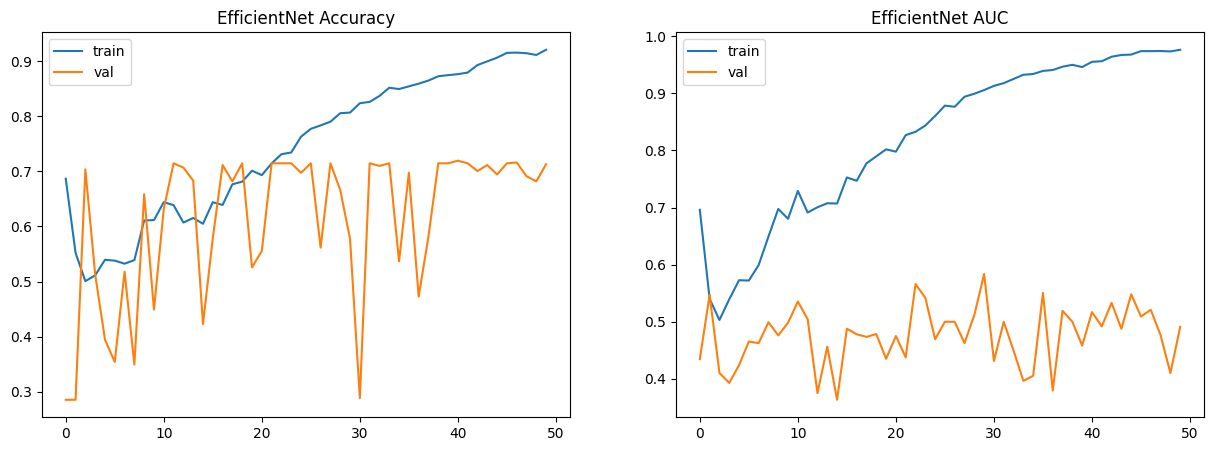

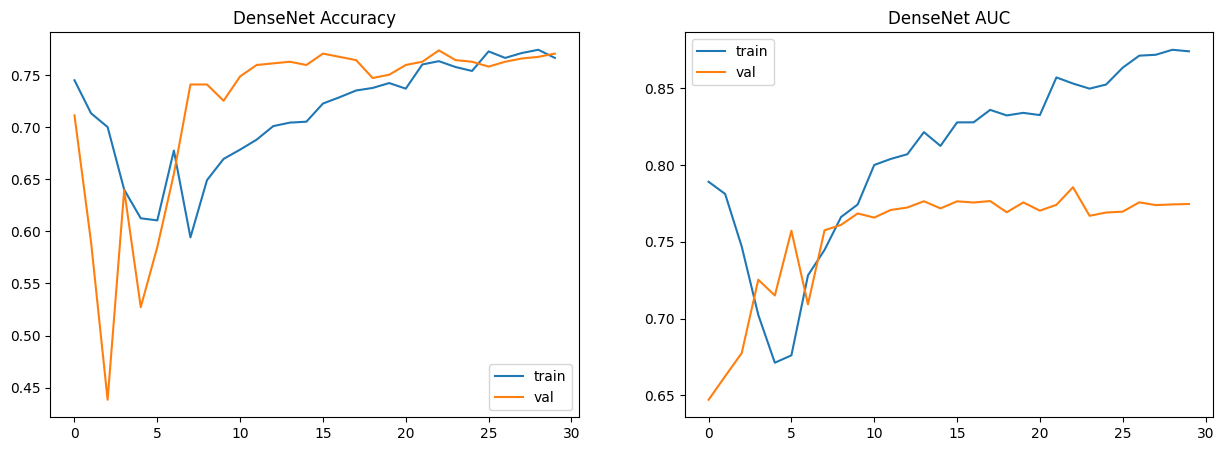

In [24]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(15,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title + " Accuracy")
    plt.legend(['train', 'val'])

    # AUC
    plt.subplot(1,2,2)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title(title + " AUC")
    plt.legend(['train', 'val'])

    plt.show()

plot_history(history_eff, "EfficientNet")
#plot_history(merge_histories_eff, "EfficientNet")
plot_history(history_dense, "DenseNet")

 

# Efficient results

In [25]:
test_loss, test_accuracy, test_auc = eff_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)

60/60 [==============================] - 19s 275ms/step - loss: 1.3324 - accuracy: 0.7435 - auc: 0.4676
Test Loss: 1.332360863685608
Test Accuracy: 0.7434691786766052
Test AUC: 0.46763354539871216


# Densenet results

In [26]:
test_loss, test_accuracy, test_auc = dense_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)

60/60 [==============================] - 10s 151ms/step - loss: 0.5389 - accuracy: 0.7790 - auc: 0.7796
Test Loss: 0.5388924479484558
Test Accuracy: 0.7789968848228455
Test AUC: 0.7796391248703003


In [31]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def sensitivity_specificity(y_true, y_pred):
    """
    Compute sensitivity (TPR) and specificity (TNR) from true/pred labels.
    """
    cm = confusion_matrix(y_true, y_pred)

    # Handle cases where confusion matrix isn't 2x2
    if cm.shape != (2, 2):
        # If only one class exists, define sens/spec in a safe way
        return np.nan, np.nan

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return sensitivity, specificity


def safe_auc(y_true, y_score):
    """
    Compute AUC safely. If only one class present, return NaN instead of crashing.
    """
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_score)


def calculate_group_metrics(model, test_generator):
    """
    Calculate accuracy, AUC, sensitivity, and specificity for:
      - overall group
      - male group
      - female group
    Assumes genders: 0=female, 1=male
    """

    all_predictions = []
    all_labels = []
    all_genders = []

    for i in range(len(test_generator)):
        images, labels, genders = test_generator[i]
        predictions = model.predict(images, verbose=0).reshape(-1)

        all_predictions.extend(predictions)
        all_labels.extend(labels)
        all_genders.extend(genders)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels).astype(int)
    all_genders = np.array(all_genders).astype(int)

    # Binary predictions at threshold 0.5
    binary_predictions = (all_predictions > 0.5).astype(int)

    # ---- Overall metrics ----
    overall_accuracy = accuracy_score(all_labels, binary_predictions)
    overall_auc = safe_auc(all_labels, all_predictions)
    overall_sens, overall_spec = sensitivity_specificity(all_labels, binary_predictions)

    # ---- Male metrics ----
    male_mask = all_genders == 1
    male_accuracy = accuracy_score(all_labels[male_mask], binary_predictions[male_mask])
    male_auc = safe_auc(all_labels[male_mask], all_predictions[male_mask])
    male_sens, male_spec = sensitivity_specificity(
        all_labels[male_mask], binary_predictions[male_mask]
    )

    # ---- Female metrics ----
    female_mask = all_genders == 0
    female_accuracy = accuracy_score(all_labels[female_mask], binary_predictions[female_mask])
    female_auc = safe_auc(all_labels[female_mask], all_predictions[female_mask])
    female_sens, female_spec = sensitivity_specificity(
        all_labels[female_mask], binary_predictions[female_mask]
    )

    # Print nicely
    print("Overall Group:")
    print(f"  Accuracy:    {overall_accuracy:.3f}")
    print(f"  AUC:         {overall_auc:.3f}" if not np.isnan(overall_auc) else "  AUC:         NaN (single-class)")
    print(f"  Sensitivity: {overall_sens:.3f}" if not np.isnan(overall_sens) else "  Sensitivity: NaN (single-class)")
    print(f"  Specificity: {overall_spec:.3f}" if not np.isnan(overall_spec) else "  Specificity: NaN (single-class)")

    print("Male Group:")
    print(f"  Accuracy:    {male_accuracy:.3f}")
    print(f"  AUC:         {male_auc:.3f}" if not np.isnan(male_auc) else "  AUC:         NaN (single-class)")
    print(f"  Sensitivity: {male_sens:.3f}" if not np.isnan(male_sens) else "  Sensitivity: NaN (single-class)")
    print(f"  Specificity: {male_spec:.3f}" if not np.isnan(male_spec) else "  Specificity: NaN (single-class)")

    print("Female Group:")
    print(f"  Accuracy:    {female_accuracy:.3f}")
    print(f"  AUC:         {female_auc:.3f}" if not np.isnan(female_auc) else "  AUC:         NaN (single-class)")
    print(f"  Sensitivity: {female_sens:.3f}" if not np.isnan(female_sens) else "  Sensitivity: NaN (single-class)")
    print(f"  Specificity: {female_spec:.3f}" if not np.isnan(female_spec) else "  Specificity: NaN (single-class)")

    return {
        "overall": {
            "accuracy": overall_accuracy,
            "auc": overall_auc,
            "sensitivity": overall_sens,
            "specificity": overall_spec,
        },
        "male": {
            "accuracy": male_accuracy,
            "auc": male_auc,
            "sensitivity": male_sens,
            "specificity": male_spec,
        },
        "female": {
            "accuracy": female_accuracy,
            "auc": female_auc,
            "sensitivity": female_sens,
            "specificity": female_spec,
        },
    }


# ---------------------------
# Custom generator 
class CustomDataGenerator:
    def __init__(self, images, labels, genders, batch_size=32):
        self.images = images
        self.labels = labels
        self.genders = genders
        self.batch_size = batch_size
        self.n = len(images)

    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_g = self.genders[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y, batch_g


# Example usage with dummy data (replace with your actual data)
sample_images = np.random.rand(100, 224, 224, 3)
sample_labels = np.random.randint(0, 2, 100)
sample_genders = np.random.randint(0, 2, 100)

test_generator = CustomDataGenerator(sample_images, sample_labels, sample_genders, batch_size=32)


print("Efficient Net:")
try:
    metrics = calculate_group_metrics(eff_model, test_generator)
    print("Metrics calculated successfully!")
except NameError as e:
    print(f"Error: {e}")
    print("Make sure 'eff_model' is defined and trained before calling this function.")

print("-------------------------------------")

print("Dense Net:")
try:
    metrics = calculate_group_metrics(dense_model, test_generator)
    print("Metrics calculated successfully!")
except NameError as e:
    print(f"Error: {e}")
    print("Make sure 'dense_model' is defined and trained before calling this function.")


Efficient Net:
Overall Group:
  Accuracy:    0.470
  AUC:         0.536
  Sensitivity: 0.000
  Specificity: 1.000
Male Group:
  Accuracy:    0.519
  AUC:         0.534
  Sensitivity: 0.000
  Specificity: 1.000
Female Group:
  Accuracy:    0.413
  AUC:         0.520
  Sensitivity: 0.000
  Specificity: 1.000
Metrics calculated successfully!
-------------------------------------
Dense Net:
Overall Group:
  Accuracy:    0.470
  AUC:         0.655
  Sensitivity: 0.000
  Specificity: 1.000
Male Group:
  Accuracy:    0.519
  AUC:         0.665
  Sensitivity: 0.000
  Specificity: 1.000
Female Group:
  Accuracy:    0.413
  AUC:         0.653
  Sensitivity: 0.000
  Specificity: 1.000
Metrics calculated successfully!
